## **Librerías**

In [2]:
import pandas as pd
import numpy as np

In [3]:
pd.options.display.max_columns = False

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [149]:
import scipy.stats as stats
import statsmodels.stats.api as sms
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [39]:
from math import ceil

## **Datos**

In [11]:
df = pd.read_csv('../../../Data/Raw/ab_data.csv')

In [14]:
df.sample(5)

,user_id,timestamp,group,landing_page,converted
66959,937178,2017-01-19 00:16:20.229199,control,old_page,0
256720,898573,2017-01-05 10:00:27.577792,control,old_page,0
48047,661320,2017-01-20 20:01:02.146938,treatment,new_page,0
31328,653037,2017-01-03 14:23:00.131798,treatment,new_page,0
249519,891295,2017-01-24 02:30:44.181721,treatment,new_page,0


In [21]:
df.shape

(294478, 5)

In [17]:
df.value_counts('group')

group
treatment    147276
control      147202
Name: count, dtype: int64

In [22]:
df.groupby(['group', 'converted'])[['user_id']].count().reset_index()

,group,converted,user_id
0,control,0,129479
1,control,1,17723
2,treatment,0,129762
3,treatment,1,17514


## **Diseño del experimento**

### **Planteamiento de las hipótesis**

En el equipo de producto de una empresa de comercio electrónico en línea de tamaño medio, el diseñador de UX trabajó muy duro en una nueva versión de la página del producto, con la esperanza de que condujera a una mayor tasa de conversión. 

El gerente de producto (PM) le dijo que la tasa de conversión actual es de aproximadamente el 13% en promedio durante todo el año, y que el equipo estaría contento con un aumento del 2%, lo que significa que el nuevo diseño se considerará un éxito si eleva la tasa de conversión al 15%.


In [ ]:
tasa_actual = 0.13
tasa_esperada = 0.15


     Ho: P == Po 
     Ha: P != Po 

Nivel de confianza del 95%

In [32]:
alpha = 0.05

**Si la probabilidad de observar un resultado como extremo o mayor (valor p) es inferior a α, entonces rechazamos la hipótesis nula**

### **Selección de la muestra**

In [31]:
effect_size = sms.proportion_effectsize(tasa_actual, tasa_esperada)
effect_size

-0.0576728617308947

In [51]:
required_n = sms.NormalIndPower().solve_power(
    effect_size, #Tamaño del efecto
    power=0.8, #Potencia estadística, Es la probabilidad de que la prueba detecte el efecto si este existe
    alpha=alpha, #Significancia estadística
    ratio = 1 #Proporción entre grupo contro y tratamiento, tratamiento/control
)

required_n = round(required_n)
required_n

4719

Necesitamos 4719 registros de cada grupo para evaluar el impacto del tratamiento

### **Preparación de los datos**

In [59]:
# Calculamos la cantidad de sesiones por usuario
session_counts = df['user_id'].value_counts(ascending=True)

# Calculamos cuantos usuarios tienen más de 1 sesión
multi_users = session_counts[session_counts > 1].count()

In [67]:
# De momento vamos a quitar a los usuarios con más de 1 sesión de nuestro ejercicio
users_to_drop = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(users_to_drop)]

### **Muestreo**

In [88]:
# Creamos nuestras muestras de control y tratamiento 
control_sample = df.query('group == "control"').sample(required_n, random_state=13)
treatment_sample = df.query('group == "treatment"').sample(required_n, random_state=13)

In [89]:
ab_test = pd.concat([control_sample, treatment_sample])
ab_test.reset_index(drop=True, inplace=True)
ab_test.value_counts('group')

group
control      4719
treatment    4719
Name: count, dtype: int64

### **Primeras métricas**

In [111]:
conversion_rates = ab_test.groupby('group')[['converted']]

std_p = lambda x: np.std(x, ddof=0)
se_p = lambda x: stats.sem(x, ddof=0)

In [112]:
conversion_rates = conversion_rates.agg(['mean', std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'desv_est_pob', 'error_est_pob']
conversion_rates.style.format('{:.3f}')

,conversion_rate,desv_est_pob,error_est_pob
group,,,
control,0.120,0.325,0.005
treatment,0.123,0.328,0.005


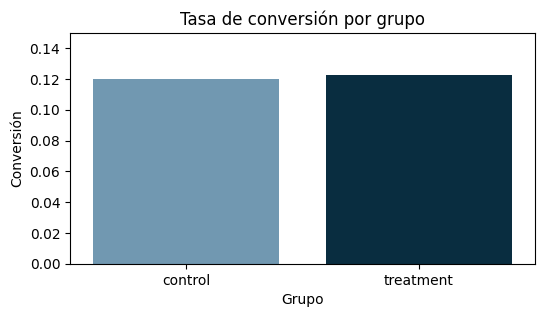

In [146]:
fig, ax = plt.subplots(figsize=(6, 3))

palette = {'treatment': '#003049', 'control': '#669bbc'}

sns.barplot(
    data=ab_test,
    x='group',
    y='converted',
    errorbar=('ci', False),
    hue='group',
    palette=palette
)

plt.title('Tasa de conversión por grupo')

plt.ylim(0, 0.15)

plt.xlabel('Grupo')
plt.ylabel('Conversión')

plt.show()

### **Evaluación de las hipótesis**

In [152]:
control_results = ab_test.query('group == "control"')['converted']
treatment_results = ab_test.query('group == "treatment"')['converted']

In [157]:
successes = [control_results.sum(), treatment_results.sum()]
observations = [control_results.count(), treatment_results.count()]

In [163]:
# Calculo del estadístico Z
z_stat, pval = proportions_ztest(successes, nobs=observations)
z_stat, pval

(-0.37818062654836326, 0.7052964163972202)

In [164]:
# Calculo de los intervalos de confianza
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=observations, alpha=alpha)

In [167]:
print(f'Estadístico Z: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'IdC 95% para grupo control: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'IdC 95% par grupo de tratamiento: [{lower_treat:.3f}, {upper_treat:.3f}]')

Estadístico Z: -0.38
p-value: 0.705
IdC 95% para grupo control: [0.111, 0.129]
IdC 95% par grupo de tratamiento: [0.113, 0.132]


### **Conclusiones**

Nuestro valor p es del **0.705** lo que esta muy por encima de nuestro alpha de **0.05**

Por tal motivo no podemos rechazar nuestra hipótesis nula

     Ho: P == Po 

Esto significa que las diferencias entre el grupo de control y tratamiento no son signigicativas por lo que el tratamiento no tiene el eimpacto esperado para nuestro experimento.